In [1]:
import pickle
import json
import ast
import pandas as pd

from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn_crfsuite import CRF

from model.crf_utils import Custom_CRF
from evaluate_qa_utils import get_likelihoods, string_to_token_index, find_property_to_questionid, substring_match, complete_match

In [2]:
DEV_QUESTIONS_FILENAME = "data/preprocessedData/dev_questions.csv"
MODEL_PREDICTIONS_FILENAME = "data/model_predictions/nlnet (single model) (Microsoft Research Asia).json"
MODEL_FILENAME = "model/trainedModels/crf_sample_1000.obj"


In [3]:
DF_MODEL_PREDICTIONS = pd.DataFrame()
with open(MODEL_PREDICTIONS_FILENAME) as json_data:
    JSON_DICT = json.load(json_data)
    for question_id in JSON_DICT.keys():
        DF_MODEL_PREDICTIONS = DF_MODEL_PREDICTIONS.append({"question_id": question_id,
                                                            "answer": JSON_DICT[question_id]},
                                                           ignore_index=True)
DF_MODEL_PREDICTIONS.head()


,answer,question_id
0,the environment in which they lived,5730a0778ab72b1400f9c60b
1,,5ad2772cd7d075001a42953e
2,geographers,5acff6ea77cf76001a686682
3,700,5ad4fd0f5b96ef001a10a899
4,,5ad49faaba00c4001a268e24


In [4]:
DF_DEV_QUESTIONS = pd.read_csv(DEV_QUESTIONS_FILENAME, index_col="question_id")
DF_DEV_QUESTIONS.head()


,Unnamed: 0,paragraph_context,question_text,correct_answer,correct_answer_char_index,correct_answer_text,correct_answer_token_index,paragraph_context_tokens,plausible_answer_char_index,plausible_answer_text,plausible_answer_token_index
question_id,,,,,,,,,,,
56ddde6b9a695914005b9628,0,The Normans (Norman: Nourmands; French: Norman...,In what country is Normandy located?,NaN,"[(159, 165), (159, 165), (159, 165), (159, 165)]","['France', 'France', 'France', 'France']","[(34, 35), (34, 35), (34, 35), (34, 35)]","['The', 'Normans', '(', 'Norman', ':', 'Nourma...",[],[],[]
56ddde6b9a695914005b9629,1,The Normans (Norman: Nourmands; French: Norman...,When were the Normans in Normandy?,NaN,"[(94, 117), (87, 117), (94, 117), (94, 117)]","['10th and 11th centuries', 'in the 10th and 1...","[(21, 25), (19, 25), (21, 25), (21, 25)]","['The', 'Normans', '(', 'Norman', ':', 'Nourma...",[],[],[]
56ddde6b9a695914005b962a,2,The Normans (Norman: Nourmands; French: Norman...,From which countries did the Norse originate?,NaN,"[(256, 283), (256, 283), (256, 283), (256, 283)]","['Denmark, Iceland and Norway', 'Denmark, Icel...","[(55, 60), (55, 60), (55, 60), (55, 60)]","['The', 'Normans', '(', 'Norman', ':', 'Nourma...",[],[],[]
56ddde6b9a695914005b962b,3,The Normans (Norman: Nourmands; French: Norman...,Who was the Norse leader?,NaN,"[(308, 313), (308, 313), (308, 313), (308, 313)]","['Rollo', 'Rollo', 'Rollo', 'Rollo']","[(65, 66), (65, 66), (65, 66), (65, 66)]","['The', 'Normans', '(', 'Norman', ':', 'Nourma...",[],[],[]
56ddde6b9a695914005b962c,4,The Normans (Norman: Nourmands; French: Norman...,What century did the Normans first gain their ...,NaN,"[(671, 683), (649, 683), (671, 675), (671, 675)]","['10th century', 'the first half of the 10th c...","[(127, 129), (122, 129), (127, 128), (127, 128)]","['The', 'Normans', '(', 'Norman', ':', 'Nourma...",[],[],[]


In [5]:
with open(MODEL_FILENAME, 'rb') as f:
    crf = pickle.load(f)

In [6]:
text = "A Japan-exclusive manga series based on Twilight Princess, penned and illustrated by Akira Himekawa, was first released on February 8, 2016. The series is available solely via publisher Shogakukan's MangaOne mobile application. While the manga adaptation began almost ten years after the initial release of the game on which it is based, it launched only a month before the release of the high-definition remake."
y_true = ['O', 'I', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'I', 'I', 'O', 'O', 'O', 'O', 'O', 'I', 'I', 'I', 'I', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'I', 'O', 'O', 'I', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

assert get_likelihoods(text, [(16, 18)], [(16, 18)], crf)[0] == 0.4522455631369173
assert string_to_token_index(text, "Twilight Princess") == [(8, 10)]
assert find_property_to_questionid("56ddde6b9a695914005b9628", "paragraph_context", DF_DEV_QUESTIONS)[:11] == "The Normans"


In [7]:
DF_MODEL_PREDICTIONS["paragraph"] = [find_property_to_questionid(question_id, "paragraph_context", DF_DEV_QUESTIONS) for question_id in DF_MODEL_PREDICTIONS["question_id"]]
DF_MODEL_PREDICTIONS["correct_answer_text"] = [ast.literal_eval(find_property_to_questionid(question_id, "correct_answer_text", DF_DEV_QUESTIONS)) for question_id in DF_MODEL_PREDICTIONS["question_id"]]
DF_MODEL_PREDICTIONS["correct_answer_token_index"] = [ast.literal_eval(find_property_to_questionid(question_id, "correct_answer_token_index", DF_DEV_QUESTIONS)) for question_id in DF_MODEL_PREDICTIONS["question_id"]]
DF_MODEL_PREDICTIONS["answer_token_index"] = [string_to_token_index(paragraph, answer) if not paragraph is None else [] for paragraph, answer in tqdm(zip(DF_MODEL_PREDICTIONS["paragraph"], DF_MODEL_PREDICTIONS["answer"]))]
DF_MODEL_PREDICTIONS.head()


11873it [06:32, 35.58it/s]


,answer,question_id,paragraph,correct_answer_text,correct_answer_token_index,answer_token_index
0,the environment in which they lived,5730a0778ab72b1400f9c60b,The concept environmental determinism served a...,"[the environment in which they lived, environm...","[(29, 35), (30, 35), (30, 31), (29, 35), (30, ...","[(29, 35)]"
1,,5ad2772cd7d075001a42953e,"The notion ""force"" keeps its meaning in quantu...",[],[],[]
2,geographers,5acff6ea77cf76001a686682,The Royal Geographical Society of London and o...,[],[],"[(46, 47)]"
3,700,5ad4fd0f5b96ef001a10a899,"Today, Warsaw has some of the best medical fac...",[],[],"[(86, 87)]"
4,,5ad49faaba00c4001a268e24,Disorders of the immune system can result in a...,[],[],[]


In [8]:
all_answer_likelihoods = []
all_correct_answer_likelihood = []
for index, row in tqdm(DF_MODEL_PREDICTIONS.iterrows()):
    paragraph = row["paragraph"]
    correct_answer_token_indices = row["correct_answer_token_index"]
    answer_token_indices = row["answer_token_index"]
    correct_answer_likelihood, answer_likelihood = get_likelihoods(paragraph, correct_answer_token_indices, answer_token_indices, crf)
    all_correct_answer_likelihood.append(correct_answer_likelihood)
    all_answer_likelihoods.append(answer_likelihood)

DF_MODEL_PREDICTIONS["answer_likelihood"] = all_answer_likelihoods
DF_MODEL_PREDICTIONS["correct_answer_likelihood"] = all_correct_answer_likelihood


11873it [15:21, 12.88it/s]


In [9]:
DF_MODEL_PREDICTIONS.head()


,answer,question_id,paragraph,correct_answer_text,correct_answer_token_index,answer_token_index,answer_likelihood,correct_answer_likelihood
0,the environment in which they lived,5730a0778ab72b1400f9c60b,The concept environmental determinism served a...,"[the environment in which they lived, environm...","[(29, 35), (30, 35), (30, 31), (29, 35), (30, ...","[(29, 35)]",0.103670,0.10367
1,,5ad2772cd7d075001a42953e,"The notion ""force"" keeps its meaning in quantu...",[],[],[],NaN,NaN
2,geographers,5acff6ea77cf76001a686682,The Royal Geographical Society of London and o...,[],[],"[(46, 47)]",0.092615,NaN
3,700,5ad4fd0f5b96ef001a10a899,"Today, Warsaw has some of the best medical fac...",[],[],"[(86, 87)]",0.399505,NaN
4,,5ad49faaba00c4001a268e24,Disorders of the immune system can result in a...,[],[],[],NaN,NaN


In [10]:
DF_MODEL_PREDICTIONS["complete_match"] = [complete_match(correct_answer_text, answer)
                                          for correct_answer_text, answer 
                                          in zip(DF_MODEL_PREDICTIONS["correct_answer_text"], DF_MODEL_PREDICTIONS["answer"])]


In [11]:
DF_MODEL_PREDICTIONS["substring_match"] = [substring_match(correct_answer_text, answer)
                                           for correct_answer_text, answer
                                           in zip(DF_MODEL_PREDICTIONS["correct_answer_text"], DF_MODEL_PREDICTIONS["answer"])]



In [12]:
DF_MODEL_PREDICTIONS.head(50)


,answer,question_id,paragraph,correct_answer_text,correct_answer_token_index,answer_token_index,answer_likelihood,correct_answer_likelihood,complete_match,substring_match
0,the environment in which they lived,5730a0778ab72b1400f9c60b,The concept environmental determinism served a...,"[the environment in which they lived, environm...","[(29, 35), (30, 35), (30, 31), (29, 35), (30, ...","[(29, 35)]",0.103670,0.103670,True,True
1,,5ad2772cd7d075001a42953e,"The notion ""force"" keeps its meaning in quantu...",[],[],[],NaN,NaN,False,False
2,geographers,5acff6ea77cf76001a686682,The Royal Geographical Society of London and o...,[],[],"[(46, 47)]",0.092615,NaN,False,False
3,700,5ad4fd0f5b96ef001a10a899,"Today, Warsaw has some of the best medical fac...",[],[],"[(86, 87)]",0.399505,NaN,False,False
4,,5ad49faaba00c4001a268e24,Disorders of the immune system can result in a...,[],[],[],NaN,NaN,False,False
5,It was the first network to make the hosts res...,57263dcd89a1e219009ac5a3,The CYCLADES packet switching network was a Fr...,[to make the hosts responsible for reliable de...,"[(45, 61), (42, 55), (48, 55)]","[(40, 55)]",0.288942,0.288942,False,True
6,,572ff4ca04bcaa1900d76f24,"From here, the situation becomes more complica...","[west, west, west]","[(36, 37), (36, 37), (36, 37)]",[],NaN,0.112958,False,False
7,Fresno Normal School,5725dd7d89a1e219009abfed,The popular neighborhood known as the Tower Di...,"[Fresno Normal School, Fresno Normal School, F...","[(161, 164), (161, 164), (161, 164)]","[(161, 164)]",0.309152,0.309152,True,True
8,Mnemiopsis,572683075951b619008f7515,"Almost all species are hermaphrodites, in othe...","[Mnemiopsis, Mnemiopsis, Mnemiopsis]","[(105, 106), (105, 106), (105, 106)]","[(105, 106)]",0.184835,0.184835,True,True
9,,5ad4a049ba00c4001a268e43,Immunology is a science that examines the stru...,[],[],[],NaN,NaN,False,False


In [13]:
DF_MODEL_PREDICTIONS_PRED_ANSABLE = DF_MODEL_PREDICTIONS[DF_MODEL_PREDICTIONS["answer"] != ""]
DF_MODEL_PREDICTIONS_PRED_ANSABLE_IS_NONANSABLE = DF_MODEL_PREDICTIONS_PRED_ANSABLE[[row == [] for row in DF_MODEL_PREDICTIONS_PRED_ANSABLE["correct_answer_text"]]]
print("#PredAnswerable - IsNonanswerable", len(DF_MODEL_PREDICTIONS_PRED_ANSABLE_IS_NONANSABLE))

#PredAnswerable - IsNonanswerable 1069


In [14]:
DF_MODEL_PREDICTIONS_PRED_ANSABLE_IS_ANSABLE = DF_MODEL_PREDICTIONS_PRED_ANSABLE[[row != [] for row in DF_MODEL_PREDICTIONS_PRED_ANSABLE["correct_answer_text"]]]
print("#PredAnswerable - IsAnswerable", len(DF_MODEL_PREDICTIONS_PRED_ANSABLE_IS_ANSABLE))

#PredAnswerable - IsAnswerable 4888


In [15]:
DF_MODEL_PREDICTIONS_PRED_NONANSABLE = DF_MODEL_PREDICTIONS[DF_MODEL_PREDICTIONS["answer"] == ""]
DF_MODEL_PREDICTIONS_PRED_NONANSABLE_IS_NONANSABLE = DF_MODEL_PREDICTIONS_PRED_NONANSABLE[[row == [] for row in DF_MODEL_PREDICTIONS_PRED_NONANSABLE["correct_answer_text"]]]
print("#PredNonanswerable - IsNonanswerable", len(DF_MODEL_PREDICTIONS_PRED_NONANSABLE_IS_NONANSABLE))

#PredNonanswerable - IsNonanswerable 4876


In [16]:
DF_MODEL_PREDICTIONS_PRED_NONANSABLE_IS_ANSABLE = DF_MODEL_PREDICTIONS_PRED_NONANSABLE[[row != [] for row in DF_MODEL_PREDICTIONS_PRED_NONANSABLE["correct_answer_text"]]]
print("#PredNonanswerable - IsAnswerable", len(DF_MODEL_PREDICTIONS_PRED_NONANSABLE_IS_ANSABLE))

#PredNonanswerable - IsAnswerable 1040


<function matplotlib.pyplot.show(*args, **kw)>

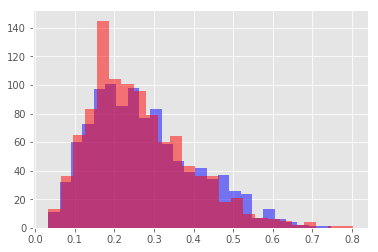

In [17]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.hist(DF_MODEL_PREDICTIONS_PRED_ANSABLE_IS_NONANSABLE["answer_likelihood"].dropna(),
        25,
        facecolor='blue',
        alpha=0.5)
ax.hist(DF_MODEL_PREDICTIONS_PRED_NONANSABLE_IS_ANSABLE["correct_answer_likelihood"].dropna(),
        25,
        facecolor='red',
        alpha=0.5)
plt.show

In [18]:
DF_MODEL_PREDICTIONS_DROPNA = DF_MODEL_PREDICTIONS.dropna(subset=["answer_likelihood", "correct_answer_likelihood"])

DF_MODEL_PREDICTIONS_correct = DF_MODEL_PREDICTIONS_DROPNA[DF_MODEL_PREDICTIONS_DROPNA["substring_match"] == True]
DF_MODEL_PREDICTIONS_wrong = DF_MODEL_PREDICTIONS_DROPNA[DF_MODEL_PREDICTIONS_DROPNA["substring_match"] == False]
print("#PredAnswerable - IsAnswerable - True", len(DF_MODEL_PREDICTIONS_correct))
print("#PredAnswerable - IsAnswerable - False", len(DF_MODEL_PREDICTIONS_wrong))


#PredAnswerable - IsAnswerable - True 4586
#PredAnswerable - IsAnswerable - False 260


In [19]:
len(DF_MODEL_PREDICTIONS_correct)

4586

In [20]:
len(DF_MODEL_PREDICTIONS_wrong)

260

In [21]:
DF_MODEL_PREDICTIONS_DROPNA


,answer,question_id,paragraph,correct_answer_text,correct_answer_token_index,answer_token_index,answer_likelihood,correct_answer_likelihood,complete_match,substring_match
0,the environment in which they lived,5730a0778ab72b1400f9c60b,The concept environmental determinism served a...,"[the environment in which they lived, environm...","[(29, 35), (30, 35), (30, 31), (29, 35), (30, ...","[(29, 35)]",0.103670,0.103670,True,True
5,It was the first network to make the hosts res...,57263dcd89a1e219009ac5a3,The CYCLADES packet switching network was a Fr...,[to make the hosts responsible for reliable de...,"[(45, 61), (42, 55), (48, 55)]","[(40, 55)]",0.288942,0.288942,False,True
7,Fresno Normal School,5725dd7d89a1e219009abfed,The popular neighborhood known as the Tower Di...,"[Fresno Normal School, Fresno Normal School, F...","[(161, 164), (161, 164), (161, 164)]","[(161, 164)]",0.309152,0.309152,True,True
8,Mnemiopsis,572683075951b619008f7515,"Almost all species are hermaphrodites, in othe...","[Mnemiopsis, Mnemiopsis, Mnemiopsis]","[(105, 106), (105, 106), (105, 106)]","[(105, 106)]",0.184835,0.184835,True,True
11,European Council,5725c743ec44d21400f3d54d,Although the European Union does not have a co...,"[The ""European Council"", The ""European Council...","[(164, 169), (164, 169), (164, 169), (164, 169)]","[(166, 168)]",0.301691,0.301691,False,True
12,J.I. Pontanus,57264a74708984140094c18b,Gasquet (1908) claimed that the Latin name atr...,"[Gasquet, Gasquet, Gasquet]","[(0, 1), (0, 1), (0, 1)]","[(35, 37)]",0.459543,0.203174,False,False
13,Sydney,57274971708984140094dbbd,"Although most are non-aligned, some of the bes...","[Sydney, Sydney, Sydney]","[(132, 133), (132, 133), (132, 133)]","[(132, 133)]",0.236161,0.236161,True,True
14,nine,572871bd3acd2414000dfa06,After the death of Tugh Temür in 1332 and subs...,"[nine, nine, nine]","[(36, 37), (36, 37), (36, 37)]","[(36, 37)]",0.326315,0.326315,True,True
19,a series of strikes by coal miners and railroa...,572649d8f1498d1400e8db37,Despite being relatively unaffected by the emb...,"[a series of strikes, a series of strikes by c...","[(19, 23), (19, 29), (19, 29), (22, 29), (19, ...","[(19, 29)]",0.224737,0.224737,True,True
20,phagosome,572905ce1d04691400778f85,Phagocytosis is an important feature of cellul...,"[phagosome, phagosome, phagosome]","[(64, 65), (64, 65), (64, 65)]","[(64, 65)]",0.130732,0.130732,True,True


{'whiskers': [<matplotlib.lines.Line2D at 0x7fc6a9267710>,
 'caps': [<matplotlib.lines.Line2D at 0x7fc6a9267fd0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fc6a9277cc0>,
 'medians': [<matplotlib.lines.Line2D at 0x7fc6a925c860>,
 'fliers': [<matplotlib.lines.Line2D at 0x7fc6a925cc88>,
 'means': []}

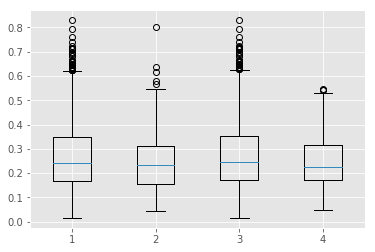

In [22]:
plt.boxplot([DF_MODEL_PREDICTIONS_correct["answer_likelihood"],
             DF_MODEL_PREDICTIONS_wrong["answer_likelihood"],
             DF_MODEL_PREDICTIONS_correct["correct_answer_likelihood"],
             DF_MODEL_PREDICTIONS_wrong["correct_answer_likelihood"]])



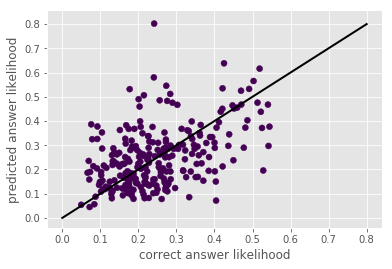

In [23]:
plt.scatter(DF_MODEL_PREDICTIONS_wrong["correct_answer_likelihood"],
            DF_MODEL_PREDICTIONS_wrong["answer_likelihood"],
            c=DF_MODEL_PREDICTIONS_wrong["substring_match"])
plt.plot([0, 0.8], [0, 0.8], color='k', linestyle='-', linewidth=2)
plt.xlabel('correct answer likelihood')
plt.ylabel('predicted answer likelihood')
plt.savefig("scatte_wrong_answers.jpg")
plt.show()


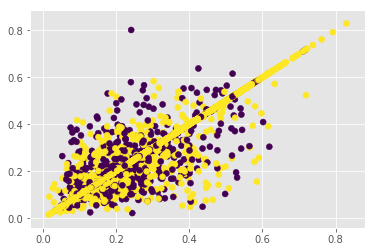

In [24]:
plt.scatter(DF_MODEL_PREDICTIONS_DROPNA["correct_answer_likelihood"],
            DF_MODEL_PREDICTIONS_DROPNA["answer_likelihood"],
            c=DF_MODEL_PREDICTIONS_DROPNA["complete_match"])



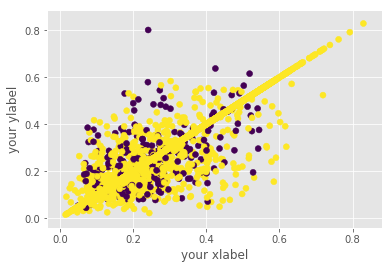

In [25]:
plt.scatter(DF_MODEL_PREDICTIONS_DROPNA["correct_answer_likelihood"],
            DF_MODEL_PREDICTIONS_DROPNA["answer_likelihood"],
            c=DF_MODEL_PREDICTIONS_DROPNA["substring_match"])
plt.xlabel('your xlabel')
plt.ylabel('your ylabel')
plt.show()

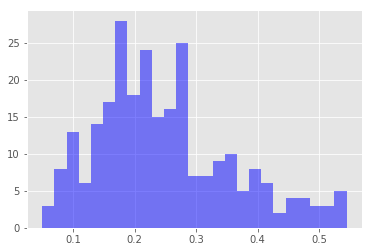

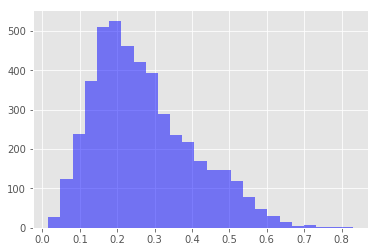

In [26]:
BINS = 25
plt.hist(DF_MODEL_PREDICTIONS_wrong["correct_answer_likelihood"],
         BINS,
         facecolor='blue',
         alpha=0.5)
plt.show()
plt.hist(DF_MODEL_PREDICTIONS_correct["correct_answer_likelihood"],
         BINS,
         facecolor='blue',
         alpha=0.5)
plt.show()


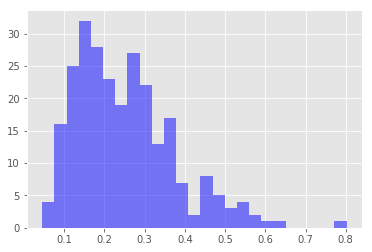

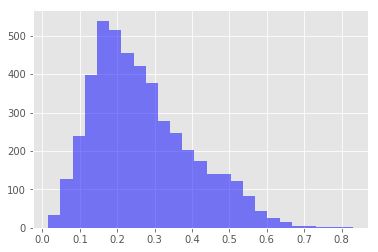

In [28]:
plt.hist(DF_MODEL_PREDICTIONS_wrong["answer_likelihood"],
         BINS,
         facecolor='blue',
         alpha=0.5)
plt.show()
plt.hist(DF_MODEL_PREDICTIONS_correct["answer_likelihood"],
         BINS,
         facecolor='blue',
         alpha=0.5)
plt.show()


In [30]:
DF_MODEL_PREDICTIONS_correct.head()
DF_MODEL_PREDICTIONS_wrong.head()


,answer,question_id,paragraph,correct_answer_text,correct_answer_token_index,answer_token_index,answer_likelihood,correct_answer_likelihood,complete_match,substring_match
12,J.I. Pontanus,57264a74708984140094c18b,Gasquet (1908) claimed that the Latin name atr...,"[Gasquet, Gasquet, Gasquet]","[(0, 1), (0, 1), (0, 1)]","[(35, 37)]",0.459543,0.203174,False,False
189,an attack against the forts Shirley had erecte...,5733fc6ed058e614000b6710,"Governor Vaudreuil, who harboured ambitions to...","[Battle of Fort Bull, Battle of Fort Bull, Bat...","[(64, 68), (64, 68), (64, 68), (64, 68), (63, ...","[(48, 60)]",0.350501,0.360757,False,False
208,vegetarians,5726887e708984140094c917,Almost all ctenophores are predators – there a...,"[Almost all ctenophores are predators, predato...","[(0, 5), (4, 5), (4, 5)]","[(9, 10)]",0.173357,0.186473,False,False
282,Sophie Germain primes,572980f9af94a219006aa4d5,are prime. Prime numbers of this form are know...,"[Fermat primes, Mersenne, primorial primes, pr...","[(51, 53), (54, 55), (48, 50), (48, 50), (48, ...","[(32, 35)]",0.367595,0.313621,False,False
302,"5,792",572863363acd2414000df988,"In the fall quarter of 2014, the University of...","[15,244, 15,244, 15,244]","[(34, 35), (34, 35), (34, 35)]","[(12, 13)]",0.278484,0.323064,False,False


(array([ 30., 149., 328., 466., 683., 678., 613., 566., 491., 368., 317.,
        275., 221., 182., 171., 144.,  90.,  56.,  34.,  17.,   8.,   9.,
          2.,   2.,   2.]),
 array([0.015675  , 0.04823194, 0.08078888, 0.11334583, 0.14590277,
        0.17845972, 0.21101666, 0.2435736 , 0.27613055, 0.30868749,
        0.34124444, 0.37380138, 0.40635832, 0.43891527, 0.47147221,
        0.50402915, 0.5365861 , 0.56914304, 0.60169999, 0.63425693,
        0.66681387, 0.69937082, 0.73192776, 0.7644847 , 0.79704165,
        0.82959859]),
 <a list of 25 Patch objects>)

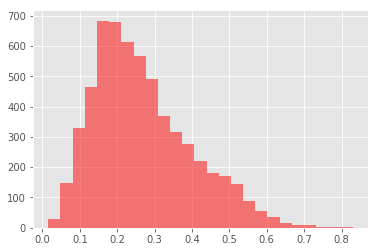

In [31]:
plt.hist(DF_MODEL_PREDICTIONS["correct_answer_likelihood"].dropna(),
        BINS,
        facecolor='red',
        alpha=0.5)

(array([ 39., 156., 313., 518., 681., 657., 572., 554., 498., 367., 318.,
        261., 222., 184., 182., 161.,  96.,  59.,  33.,  19.,   7.,   6.,
          3.,   1.,   2.]),
 array([0.015675  , 0.04823194, 0.08078888, 0.11334583, 0.14590277,
        0.17845972, 0.21101666, 0.2435736 , 0.27613055, 0.30868749,
        0.34124444, 0.37380138, 0.40635832, 0.43891527, 0.47147221,
        0.50402915, 0.5365861 , 0.56914304, 0.60169999, 0.63425693,
        0.66681387, 0.69937082, 0.73192776, 0.7644847 , 0.79704165,
        0.82959859]),
 <a list of 25 Patch objects>)

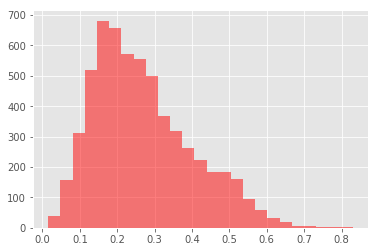

In [32]:
plt.hist(DF_MODEL_PREDICTIONS["answer_likelihood"].dropna(),
        BINS,
        facecolor='red',
        alpha=0.5)